# 10. Online Continual Learning

In machine learning, continual learning is a problem setting where a model is
trained on a sequence of tasks and must perform well on all tasks seen so far. A
task is a specific concept or relation the model expects to learn. Online
continual learning adds the constraints that the model considers each example
exactly once, and the model can perform prediction at any time.

In contrast to continual learning, the typical data stream problem setting
adapts to changes in data distribution by discarding knowledge of the past.
However, in continual learning, the model must retain knowledge of past tasks
while learning new tasks.

Continual learning is synonymous with overcoming catastrophic forgetting, a
phenomenon in deep learning where a model trained on a sequence of tasks forgets
how to perform well on the initial tasks. Non-deep learning models can be immune
to forgetting.

---

In this notebook, we implement “Experience Replay” (ER), a classic online
continual learning strategy that stores a buffer of past examples. By sampling
from the buffer during training, ER avoids catastrophic forgetting.

In [1]:
# This cell is hidden on capymoa.org. See docs/contributing/docs.rst
from util.nbmock import mock_datasets, is_nb_fast

if is_nb_fast():
    mock_datasets()

## 10.1 Reservoir Sampling

Experience Replay uses [reservoir sampling](https://en.wikipedia.org/wiki/Reservoir_sampling)
to construct a simple random sample incrementally from a data stream of unknown
length. Here, we implement reservoir sampling "Algorithm R" (Vitter, 1985).

- Jeffrey S. Vitter. 1985. Random sampling with a reservoir. ACM Trans. Math.
  Softw. 11, 1 (March 1985), 37–57. https://doi.org/10.1145/3147.3165

In [2]:
import torch
from typing import Tuple
from torch import Tensor


class ReservoirSampler:
    def __init__(self, item_count: int, feature_count: int):
        self.item_count = item_count
        self.feature_count = feature_count
        self.reservoir_x = torch.zeros((item_count, feature_count))
        self.reservoir_y = torch.zeros((item_count,), dtype=torch.long)
        self.count = 0

    def update(self, x: Tensor, y: Tensor) -> None:
        batch_size = x.shape[0]
        assert x.shape == (
            batch_size,
            self.feature_count,
        )
        assert y.shape == (batch_size,)

        for i in range(batch_size):
            if self.count < self.item_count:
                # Fill the reservoir
                self.reservoir_x[self.count] = x[i]
                self.reservoir_y[self.count] = y[i]
            else:
                # Reservoir sampling
                index = torch.randint(0, self.count + 1, (1,))
                if index < self.item_count:
                    self.reservoir_x[index] = x[i]
                    self.reservoir_y[index] = y[i]
            self.count += 1

    def sample_n(self, n: int) -> Tuple[Tensor, Tensor]:
        indices = torch.randint(0, min(self.count, self.item_count), (n,))
        return self.reservoir_x[indices], self.reservoir_y[indices]

Let's check to see if it's samples look uniform.

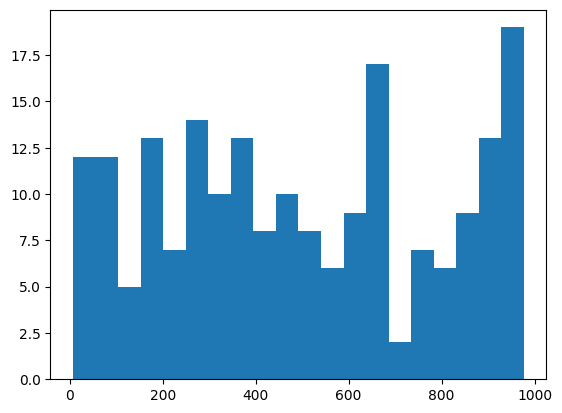

In [3]:
from matplotlib import pyplot as plt

x = torch.arange(0, 1_000).reshape(-1, 1).float()
y = torch.zeros(1_000, dtype=torch.long)
sampler = ReservoirSampler(500, 1)
sampler.update(x, y)
x = sampler.sample_n(200)
plt.hist(x[0].numpy(), bins=20)
plt.show()

## 10.2 Experience Replay


In [4]:
from capymoa.base import BatchClassifier
from capymoa.instance import Instance
from capymoa.stream import Schema
from capymoa.type_alias import LabelProbabilities
from torch.nn.functional import cross_entropy
import numpy as np
from torch import nn


class ExperienceReplay(BatchClassifier):
    def __init__(
        self,
        schema: Schema,
        model: nn.Module,
        reservoir_size: int,
        batch_size: int,
        learning_rate: float,
        device: str = "cpu",
    ):
        super().__init__(schema=schema, batch_size=batch_size)
        self.reservoir = ReservoirSampler(reservoir_size, schema.get_num_attributes())
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.model = model.to(device)
        self.device = device
        self.batch_size = batch_size

    def batch_train(self, x: np.ndarray, y: np.ndarray):
        x: Tensor = torch.from_numpy(x)
        y: Tensor = torch.from_numpy(y).long()

        self.reservoir.update(x, y)

        replay_x, replay_y = self.reservoir.sample_n(self.batch_size)
        train_x = torch.cat((x, replay_x), dim=0).to(self.device)
        train_y = torch.cat((y, replay_y), dim=0).to(self.device)

        self.optimizer.zero_grad()
        y_hat = self.model(train_x)
        loss = cross_entropy(y_hat, train_y)
        loss.backward()
        self.optimizer.step()

    @torch.no_grad
    def predict_proba(self, instance: Instance) -> LabelProbabilities:
        x = torch.from_numpy(instance.x).to(self.device)
        y_hat: Tensor = self.model.forward(x)
        return y_hat.softmax(dim=0).cpu().numpy()

    def __str__(self) -> str:
        return "ExperienceReplay"

## 10.3 Multi Layer Perceptron

We create a simple multi-layer perceptron (MLP) with a single hidden layer to demonstrate continual learning.

The output layer of a neural network is often problematic in continual learning because of the extreme and shifting
class imbalance between tasks. Lesort et al. (2021) suggest mitigating this by using a variant of weight normalization
that parameterizes the weights as a magnitude (set to the unit vector) and a direction. 

* Lesort, T., George, T., & Rish, I. (2021). Continual Learning in Deep Networks:
 An Analysis of the Last Layer.

In [5]:
class SimpleMLP(nn.Module):
    def __init__(self, schema: Schema, hidden_size: int):
        super().__init__()
        num_classes = schema.get_num_classes()

        self.fc1 = nn.Linear(schema.get_num_attributes(), hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes, bias=False)
        self.fc2 = nn.utils.parametrizations.weight_norm(self.fc2, name="weight")
        weight_g = self.fc2.parametrizations.weight.original0
        # Set the magnitude to the unit vector
        weight_g.requires_grad_(False).fill_(1.0 / (num_classes**0.5))

    def forward(self, x: Tensor) -> Tensor:
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
from capymoa.evaluation.ocl import ocl_train_eval_loop
from capymoa.datasets.ocl import SplitMNIST

stream = SplitMNIST()
mlp = SimpleMLP(stream.schema, 100)
learner = ExperienceReplay(
    stream.schema,
    mlp,
    reservoir_size=256,
    batch_size=128,
    learning_rate=0.01,
    device="cpu",
)

results = ocl_train_eval_loop(learner, stream.train_streams, stream.test_streams)

## 10.4 Evaluation

* Task 0 start high and decreases as the model forgets the task.
* Task 1-4 start at zero since the model has not seen the task yet.
* **Accuracy** is the accuracy of the learner on all previous tasks.
* **Average Accuracy** is the average accuracy of the learner on all previous
  tasks across the models lifetime.
* **Online Accuracy** is prequential test-then-train accuracy.

0.83 average accuracy on all tasks


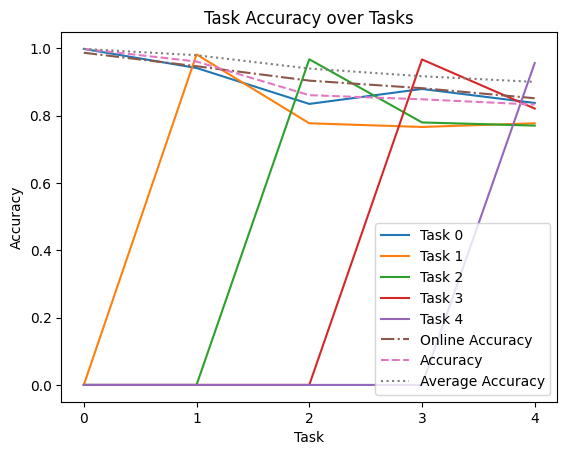

In [7]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(results.task_accuracy_matrix, label=[f"Task {i}" for i in range(5)])
ax.plot(results.online_accuracy_series, linestyle="-.", label="Online Accuracy")
ax.plot(results.accuracy_series, linestyle="--", label="Accuracy")
ax.plot(results.average_accuracy_series, linestyle=":", label="Average Accuracy")

ax.set_xlabel("Task")
ax.set_xticks(range(5))
ax.set_ylabel("Accuracy")
ax.legend()
ax.set_title("Task Accuracy over Tasks")

print(f"{results.accuracy:0.2f} average accuracy on all tasks")